In [1]:
import csv
import json
import os
import pickle
import random

import albumentations as A
import cv2
import lightning as L
import numpy as np
import scipy
import skimage
import skimage.filters
import skimage.io
import skimage.transform
import torch
from torch import nn
import torchvision
from tqdm import tqdm
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import OrderedDict
import torchmetrics
import torch.nn.functional as F

from detection_and_metrics import fit_cls_model
from numpy import load, int64
from os.path import dirname, join
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torch import argmax, from_numpy

/Users/anymax/Documents/mipt/ШАД/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/anymax/Documents/mipt/ШАД/.venv/lib/python3.12/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.16). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
%reload_ext tensorboard

In [3]:
%tensorboard --logdir simple_classifier/lightning_logs --port 8088

In [2]:
from detection_and_metrics import CarsDetectionDataset, LightningCarsDetection, get_cls_model, fit_cls_model, get_detection_model, get_detections

In [3]:
data = load('./tests/00_unittest_classifier_input/train_data.npz')
X = data['X'].reshape(-1, 1, 40, 100)   #pytorch dimensions are (N, C, H, W)
y = data['y'].astype(int64)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15)
X_train, X_test = from_numpy(X_train), from_numpy(X_test)
y_train, y_test = from_numpy(y_train), from_numpy(y_test)

In [4]:
model_first = fit_cls_model(X_train, y_train, fast_train=False, X_val=X_test, y_val=y_test)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 4.2 M  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.648    Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/anymax/Documents/mipt/ШАД/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
/Users/anymax/Documents/mipt/ШАД/.venv/lib/python3.12/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.16). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/Users/anymax/Documents/mipt/ШАД/.venv/lib/python3.12/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.16). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


/Users/anymax/Documents/mipt/ШАД/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/Users/anymax/Documents/mipt/ШАД/.venv/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (27) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0:   0%|          | 0/27 [00:00<?, ?it/s] 

/Users/anymax/Documents/mipt/ШАД/.venv/lib/python3.12/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.16). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/Users/anymax/Documents/mipt/ШАД/.venv/lib/python3.12/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.16). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Epoch 0: 100%|██████████| 27/27 [00:13<00:00,  2.01it/s, v_num=6, train_loss_step=0.00146, train_accs_step=1.000]

/Users/anymax/Documents/mipt/ШАД/.venv/lib/python3.12/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.16). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/Users/anymax/Documents/mipt/ШАД/.venv/lib/python3.12/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.16). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Epoch 1:   0%|          | 0/27 [00:00<?, ?it/s, v_num=6, train_loss_step=0.00146, train_accs_step=1.000, val_loss_step=0.115, val_accs_step=0.933, val_loss_epoch=0.205, val_accs_epoch=0.918, train_loss_epoch=2.560, train_accs_epoch=0.750]         

/Users/anymax/Documents/mipt/ШАД/.venv/lib/python3.12/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.16). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/Users/anymax/Documents/mipt/ШАД/.venv/lib/python3.12/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.16). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Epoch 1: 100%|██████████| 27/27 [00:14<00:00,  1.82it/s, v_num=6, train_loss_step=0.263, train_accs_step=0.938, val_loss_step=0.115, val_accs_step=0.933, val_loss_epoch=0.205, val_accs_epoch=0.918, train_loss_epoch=2.560, train_accs_epoch=0.750]  

/Users/anymax/Documents/mipt/ШАД/.venv/lib/python3.12/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.16). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/Users/anymax/Documents/mipt/ШАД/.venv/lib/python3.12/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.16). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Epoch 2:   0%|          | 0/27 [00:00<?, ?it/s, v_num=6, train_loss_step=0.263, train_accs_step=0.938, val_loss_step=0.0579, val_accs_step=0.967, val_loss_epoch=0.112, val_accs_epoch=0.956, train_loss_epoch=0.115, train_accs_epoch=0.961]         

/Users/anymax/Documents/mipt/ШАД/.venv/lib/python3.12/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.16). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/Users/anymax/Documents/mipt/ШАД/.venv/lib/python3.12/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.16). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Epoch 2: 100%|██████████| 27/27 [00:14<00:00,  1.88it/s, v_num=6, train_loss_step=0.012, train_accs_step=1.000, val_loss_step=0.0579, val_accs_step=0.967, val_loss_epoch=0.112, val_accs_epoch=0.956, train_loss_epoch=0.115, train_accs_epoch=0.961]  

/Users/anymax/Documents/mipt/ШАД/.venv/lib/python3.12/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.16). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/Users/anymax/Documents/mipt/ШАД/.venv/lib/python3.12/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.16). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Epoch 3:   0%|          | 0/27 [00:00<?, ?it/s, v_num=6, train_loss_step=0.012, train_accs_step=1.000, val_loss_step=0.121, val_accs_step=0.933, val_loss_epoch=0.113, val_accs_epoch=0.968, train_loss_epoch=0.0461, train_accs_epoch=0.981]         

/Users/anymax/Documents/mipt/ШАД/.venv/lib/python3.12/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.16). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/Users/anymax/Documents/mipt/ШАД/.venv/lib/python3.12/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.16). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Epoch 3: 100%|██████████| 27/27 [00:13<00:00,  2.01it/s, v_num=6, train_loss_step=0.0577, train_accs_step=0.969, val_loss_step=0.121, val_accs_step=0.933, val_loss_epoch=0.113, val_accs_epoch=0.968, train_loss_epoch=0.0461, train_accs_epoch=0.981]  

/Users/anymax/Documents/mipt/ШАД/.venv/lib/python3.12/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.16). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/Users/anymax/Documents/mipt/ШАД/.venv/lib/python3.12/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.16). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Epoch 4:   0%|          | 0/27 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0577, train_accs_step=0.969, val_loss_step=0.0803, val_accs_step=0.967, val_loss_epoch=0.159, val_accs_epoch=0.962, train_loss_epoch=0.0381, train_accs_epoch=0.987]         

/Users/anymax/Documents/mipt/ШАД/.venv/lib/python3.12/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.16). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/Users/anymax/Documents/mipt/ШАД/.venv/lib/python3.12/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.16). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Epoch 4: 100%|██████████| 27/27 [00:14<00:00,  1.89it/s, v_num=6, train_loss_step=0.00427, train_accs_step=1.000, val_loss_step=0.0803, val_accs_step=0.967, val_loss_epoch=0.159, val_accs_epoch=0.962, train_loss_epoch=0.0381, train_accs_epoch=0.987]

/Users/anymax/Documents/mipt/ШАД/.venv/lib/python3.12/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.16). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/Users/anymax/Documents/mipt/ШАД/.venv/lib/python3.12/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.16). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Epoch 4: 100%|██████████| 27/27 [00:18<00:00,  1.44it/s, v_num=6, train_loss_step=0.00427, train_accs_step=1.000, val_loss_step=0.0609, val_accs_step=0.967, val_loss_epoch=0.0945, val_accs_epoch=0.975, train_loss_epoch=0.0188, train_accs_epoch=0.994]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 27/27 [00:18<00:00,  1.44it/s, v_num=6, train_loss_step=0.00427, train_accs_step=1.000, val_loss_step=0.0609, val_accs_step=0.967, val_loss_epoch=0.0945, val_accs_epoch=0.975, train_loss_epoch=0.0188, train_accs_epoch=0.994]


In [4]:
classifier_model = get_cls_model()
classifier_model.load_state_dict(
    torch.load(
        "classifier_model.pt",
        weights_only=True,
        map_location="cpu",
    ),
)
classifier_model.eval()

LightningCarsDetection(
  (model): Sequential(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (act1): ReLU()
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (act2): ReLU()
    (max_pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act3): ReLU()
    (dropout): Dropout(p=0.2, inplace=False)
    (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act4): ReLU()
    (max_pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (flat): Flatten(start_dim=1, end_dim=-1)
    (lin1): Linear(in_features=16000, out_features=256, bias=True)
    (act_final): ReLU()
    (

In [5]:
from sklearn.metrics import accuracy_score

y_predicted = argmax(classifier_model(X_test), dim = 1)
accuracy_score(y_test, y_predicted)

0.9873417721518988

In [6]:
detection_model = get_detection_model(classifier_model)
detection_model.eval()


y_predicted = argmax(detection_model(X_test).squeeze(), dim = 1)
accuracy_score(y_test, y_predicted)

0.9873417721518988

In [7]:
img_dir = './tests/03_unittest_detector_input/test_imgs/'
gt_path = './tests/03_unittest_detector_input/true_detections.json'

In [8]:
def read_for_detection(img_dir, gt_path):
    with open(gt_path) as fp:
        raw_data = json.load(fp)

    data = {}
    for file_name, bboxes in raw_data.items():
        file_path = os.path.join(img_dir, file_name)
        image = np.array(PIL.Image.open(file_path))
        image = image.astype(np.float32) / 255
        data[file_name] = (image, bboxes)
    return data

In [9]:
import PIL

images_detection = read_for_detection(img_dir, gt_path)

In [10]:
images_detection_no_answer = {}
images_detection_only_bboxes = {}

for img_name, data in images_detection.items():
        images_detection_no_answer[img_name] = data[0]
        images_detection_only_bboxes[img_name] = data[1]

predicted_bbox = get_detections(detection_model, images_detection_no_answer)

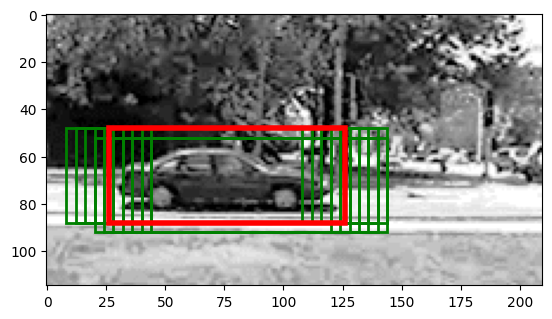

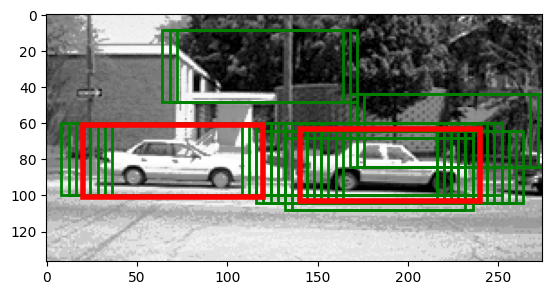

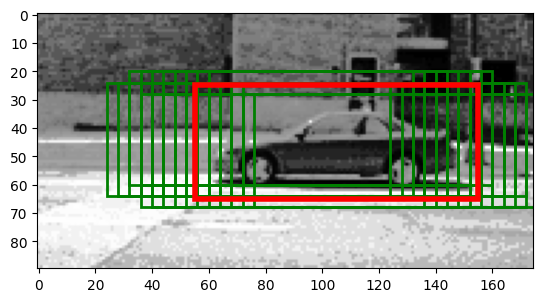

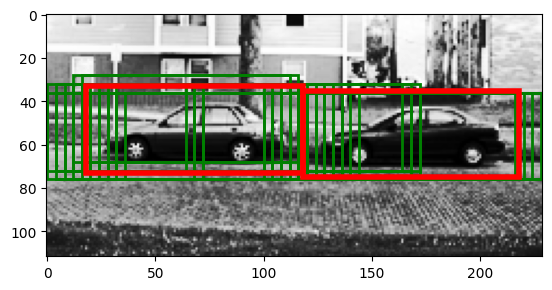

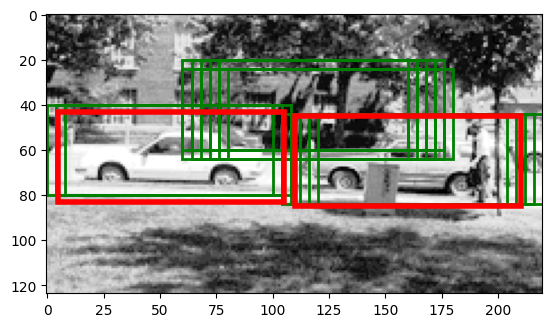

In [11]:
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt

i = 0
for filename, bbox in predicted_bbox.items():
    img = images_detection_no_answer[filename]
    gt_imgs = images_detection_only_bboxes[filename]
    fig, ax = plt.subplots()
    ax.imshow(img, cmap='gray')
    for pred in bbox:
        h, w, height, width, _ = pred
        ax.add_patch(Rectangle((w, h), width, height, linewidth=2, edgecolor='g', facecolor='none'))
    for gt in gt_imgs:
        ax.add_patch(Rectangle((gt[1], gt[0]), gt[3], gt[2], linewidth=4, edgecolor='r', facecolor='none'))
    i += 1
    if i == 5:
        break